<a href="https://colab.research.google.com/github/GiulianoPepato/Training/blob/main/teste_spfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas lxml requests

from io import StringIO
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson


def data_e_rodada(dataframe):
  dataframe['data e rodada'] = dataframe['data e rodada'].apply(lambda x: x.split())
  dataframe['rodada'] = dataframe['data e rodada'].apply(lambda x: x[3])

  dataframe['mês'] = dataframe['data e rodada'].apply(lambda x: x[1])
  dataframe['dia'] = dataframe['data e rodada'].apply(lambda x: x[0])
  dataframe = dataframe.drop(columns = ['data e rodada'])
  return dataframe

def placar(dataframe):
    dataframe['placar'] = dataframe['placar'].apply(lambda x: x.replace('–', '-').split("-")) # Corrigido aqui
    dataframe['gols casa'] = dataframe['placar'].apply(lambda x: int(x[0]))
    dataframe['gols visitante'] = dataframe['placar'].apply(lambda x: int(x[1]))
    return dataframe

def data_rodada_placar(dataframe):
  dataframe['data e rodada'] = dataframe['data e rodada'].apply(lambda x: x.split())

  dataframe['rodada'] = dataframe['data e rodada'].apply(lambda x: x[-1])

  primeiro_ano = 2006
  ultimo_ano = int(dataframe.at[len(dataframe['data e rodada']) - 1, 'data e rodada'][2])

  for j in range(ultimo_ano - primeiro_ano + 1):
    if int(primeiro_ano + j) != 2020:
      dataframe.loc[38*j : 38*(j+1), 'ano'] = int(primeiro_ano + j)
    else:
      dataframe.loc[38*j: 38*j+27, 'ano'] = 2020
      dataframe.loc[38*j+27: 38*(j+1), 'ano'] = 2021

  dataframe['mês'] = dataframe['data e rodada'].apply(lambda x: x[1])
  dataframe['dia'] = dataframe['data e rodada'].apply(lambda x: int(x[0]))

  dataframe['placar'] = dataframe['placar'].apply(lambda x: x.replace('–', '-').split("-")) # Corrigido aqui
  dataframe['gols casa'] = dataframe['placar'].apply(lambda x: int(x[0]))
  dataframe['gols visitante'] = dataframe['placar'].apply(lambda x: int(x[1]))

  dataframe['adversario'] = dataframe.apply(lambda row: row['visitante'] if row['casa'] == 'São Paulo' else row['casa'], axis=1)
  dataframe['mandante'] = dataframe.apply(lambda row: True if row['casa'] == 'São Paulo' else False, axis=1 )
  dataframe['gols spfc'] = dataframe.apply(lambda row: row['gols casa'] if row['mandante'] else row['gols visitante'], axis=1)
  dataframe['gols adv'] = dataframe.apply(lambda row: row['gols casa'] if row['mandante'] is False else row['gols visitante'], axis=1)

  dataframe = dataframe.drop(columns = ['data e rodada', 'placar', 'gols casa', 'gols visitante', 'casa', 'visitante'])
  return dataframe

def jogos_em_casa(dataframe):
  return dataframe[(dataframe['mandante'])].reset_index(drop =  True)

def jogos_fora(dataframe):
  return dataframe[~(dataframe['mandante'])].reset_index(drop =  True)

def resultados(dataframe):
  df_vitorias = dataframe[ (dataframe['gols spfc'] > dataframe['gols adv'])]
  df_empates = dataframe[ (dataframe['gols spfc'] == dataframe['gols adv'])]
  df_derrotas = dataframe[ (dataframe['gols spfc'] < dataframe['gols adv'])]
  return df_vitorias, df_empates, df_derrotas, {'vitórias': len(df_vitorias), 'empates': len(df_empates), 'derrotas': len(df_derrotas)}
def resultados_dos_adversarios(campeonato):
  vitorias, empates, derrotas, resultados_n = resultados(campeonato)
  br = campeonato

  contagem_adversarios = br['adversario'].value_counts().to_dict()
  contagem_adversarios_derrotados = vitorias['adversario'].value_counts().to_dict()
  contagem_adversarios_vitoriosos = derrotas['adversario'].value_counts().to_dict()
  contagem_adversarios_empatados = empates['adversario'].value_counts().to_dict()

  adversarios = {}
  for adv in br['adversario'].unique().tolist():
    adversario = {}

    adversario['perdeu'] = contagem_adversarios_derrotados[adv] if adv in contagem_adversarios_derrotados else 0
    adversario['empatou'] = contagem_adversarios_empatados[adv] if adv in contagem_adversarios_empatados else 0
    adversario['ganhou'] = contagem_adversarios_vitoriosos[adv] if adv in contagem_adversarios_vitoriosos else 0

    adversario['% derrotas'] =  round(adversario['perdeu']/contagem_adversarios[adv],3)*100
    adversario['% empates'] =  round(adversario['empatou']/contagem_adversarios[adv],3)*100
    adversario['% vitórias'] =  round(adversario['ganhou']/contagem_adversarios[adv],3)*100

    adversarios[adv] = adversario

  return adversarios

def dataframe_resultados_adv(campeonato):
  vitorias_df, empates_df, derrotas_df, resultados_n = resultados(campeonato)
  contagem_adversarios = campeonato['adversario'].value_counts().to_dict()

  vitorias_dos_adversarios = derrotas_df['adversario'].value_counts().to_dict()
  derrotas_dos_adversarios = vitorias_df['adversario'].value_counts().to_dict()
  empates_por_adversario = empates_df['adversario'].value_counts().to_dict()

  nomes = []
  enfrentamentos = []
  gols_feitos = []
  gols_sofridos = []
  wins = []
  loses = []
  draws = []
  p_vitorias = []
  p_derrotas = []
  p_empates = []

  for adv in campeonato['adversario'].unique().tolist():
    nomes.append(adv)
    enfrentamentos.append(contagem_adversarios[adv])

    df = campeonato[(campeonato['adversario'] == adv)]
    gols_feitos.append(sum(df['gols adv']))
    gols_sofridos.append(sum(df['gols spfc']))

    # Use .get() to safely retrieve counts, defaulting to 0 if adversary not found in that category
    wins.append(vitorias_dos_adversarios.get(adv, 0))
    loses.append(derrotas_dos_adversarios.get(adv, 0))
    draws.append(empates_por_adversario.get(adv, 0))

    p_vitorias.append(round(vitorias_dos_adversarios.get(adv, 0) / contagem_adversarios[adv], 3) * 100)
    p_derrotas.append(round(derrotas_dos_adversarios.get(adv, 0) / contagem_adversarios[adv], 3) * 100)
    p_empates.append(round(empates_por_adversario.get(adv, 0) / contagem_adversarios[adv], 3) * 100)

  return pd.DataFrame({'Time': nomes,
                       'Disputas': enfrentamentos,
                       'Gols marcados': gols_feitos,
                       'Gols sofridos': gols_sofridos,
                       'Vitorias': wins,
                       'Derrotas': loses,
                       'Empates': draws,
                       '% Vitórias': p_vitorias,
                       '% Derrotas': p_derrotas,
                       '% Empates': p_empates})

def spfc_info(dataframe):
  vitorias, empates, derrotas, resultados_n = resultados(dataframe)
  print('')
  print(f"O SPFC tem um total de {len(dataframe['gols spfc'])} partidas jogadas, possuindo: \n{resultados_n['vitórias']} vitórias \n{resultados_n['empates']} empates \n{resultados_n['derrotas']} de derrotas")
  print(f"marcando um total de {sum(dataframe['gols spfc'])} gols e fazendo {len(vitorias['gols spfc'])*3 + len(empates['gols spfc'])} pontos.")
  print('Sendo campeão nos anos de 2006, 2007 e 2008, o único clube do país a ser tricampeão brasileiro consecutivo!')
  time.sleep(4)
  print('')
  while True: # Usei o While True para que sempre a pessoa tenha que escolher
# uma das opções, a não ser que ela queira sair. Talvez usar uma função que chame
# ela mesma seja uma opção valida também
    print('Qual informação você quer saber?')
    time.sleep(1)
    print('Digite 1 para saber sobre alguma temporada específica')
    time.sleep(2)
    print('Digite 2 para saber sobre um intervalo de tempo')
    time.sleep(2)
    print('Digite 3 para saber em quais cidades jogamos')
    time.sleep(2)
    print('Digite 4 para voltar')

    options_2 = [1,2,3,4]

    try: #try é usado para garantir que o usuario escolha uma opção válida
      chave = int(input()) #se foi tentado passar um caracter que não seja um
      # num inteiro, ele cai no except
      if chave not in options_2: #se o num digitado não estiver nas opções
        print('') # ele volta para escolher uma das opções
        continue
      match chave:
        case 1:
          spfc_temporada(dataframe)
        case 2:
          spfc_intervalo(dataframe)
        case 3:
          print(f"Número de cidades onde jogamos: {len(dataframe['cidade'].unique())}")
          print('------ Lista de todas as cidades que o São Paulo jogou ------')
          for cidade in dataframe['cidade'].unique():
            print(cidade)
            time.sleep(0.5)
        case 4:
          return None

    except:
      print('Digite um número válido')
      continue


def spfc_temporada(campeonato):
  while True:
    print('')
    print('Digite um ano entre 2006 e 2025')
    try:
      ano = int(input())
      if ano in range(2006,2026):
        if ano != 2020:
          campeonato_ano = campeonato[(campeonato['ano'] == ano)].reset_index(drop=True)
        else:
          campeonato_ano = campeonato[532:570].reset_index(drop=True)
# algumas partidas do ano de 2020 foram jogadas em 2021, então  é mais fácil
# atribuir esse ano nessas datas "manualmente"
        campeonato_ano = spfc_local(campeonato_ano)
        print('')
        vitorias, empates, derrotas, resultados_n = resultados(campeonato_ano)
        print(f"No ano de {ano} o SPFC \nvenceu {len(vitorias['adversario'])} partidas, \nempatou {len(empates['adversario'])} e\nperdeu {len(derrotas['adversario'])}")
        time.sleep(4)
        print(f'conquistando um total de {len(vitorias['adversario'])*3 + len(empates['adversario'])} pontos')
        time.sleep(3)
        print(f"marcando um total de {sum(campeonato_ano['gols spfc'])} gols e sofrendo {sum(campeonato_ano['gols adv'])}")
        time.sleep(5)

        graf_pontos_spfc(campeonato_ano, ano)
        print('')
        graf_gols_spfc(campeonato_ano, ano)

        while True:
          print('Qual informação a mais você deseja?')
          print('Digite 1 para ver a tabela dos jogos')
          print('Digite 2 para ver a tabela das vitórias')
          print('Digite 3 para ver a tabela dos empates')
          print('Digite 4 para ver a tabela das derrotas')
          print('Digite 5 para voltar a seleção dos anos')
          print('Digite 6 para voltar')
          options_3 = [1,2,3,4,5,6]
          try:
            chave = int(input())
            if chave not in options_3:
              print('Digite o valor de uma das opções')
              continue

            match chave:
              case 1:
                display(campeonato_ano)
                continue
              case 2:
                display(vitorias)
                continue
              case 3:
                display(empates)
                continue
              case 4:
                display(derrotas)
                continue
              case 5:
                break
              case 6:
                return None
          except:
            print('Digite uma das opções')
      else:
        print('Digite um ano dentro do intervalo')
        pass

    except:
      print('Digite o número do ano')
      continue

def spfc_intervalo(campeonato):
  while True:

    print('Digite o ano de inicio (de 2006 a 2025)')

    try:
      ano_inicio = int(input())
      if ano_inicio not in range(2006,2026):
        print('Digite um valor dentro do intervalo de anos')
        continue

      while True:
        print(f'Digite o ano final (de {ano_inicio} a 2025)')

        try:
          ano_final = int(input())
          if ano_final not in range(ano_inicio,2026):
            print('Digite um valor dentro do intervalo de anos')
            continue
          break
        except:
          print('Digite o número do ano final')
          continue

    except:
      print('Digite o número do ano inicial')
      continue

    campeonato_ano_incio = campeonato[ (campeonato['ano'] >= ano_inicio)]
    # recebe todos os jogos com o ano com valor maior ou igual ao ano de inicio

    campeonato_ano = campeonato_ano_incio[ (campeonato_ano_incio['ano'] <= ano_final) ]
    # recebe todos os jogos com o ano menor ou igual ao ano final

    while True:
      print('Digite o mês de inicio (1 até 12)')
      try:
        mes_inicio = int(input())
        if mes_inicio not in range(1,13):
          print('Digite um valor dentro do intervalo')
          continue
        while True:
          print('Digite o mês final')
          try:
            mes_final = int(input())
            if ano_inicio == ano_final and mes_final not in range(mes_inicio,13):
# O usuario não pode escolher um mês anterior ao mês inicial se o ano de inicio
# é igual ao ano final
              print('Você não pode digitar um mês anterior ao que escolheu')
              continue
            elif mes_final not in range(1,13):
              print('Digite um mês dentro do intervalo padrão')
              continue
            else:
              pass

          except:
            print('Digite o número do mês')
            continue
          break
      except:
        print('Digite o número do mês inicial')
        continue
      break

    campeonato_mes_inicio = campeonato_ano[~( (campeonato_ano['ano'] == ano_inicio) & (campeonato_ano['mês'] < mes_inicio))]
# exclui todos os jogos com o ano incial e com o mês menor ao mes inicial
    campeonato_mes = campeonato_mes_inicio[~( (campeonato_mes_inicio['ano'] == ano_final) & (campeonato_mes_inicio['mês'] > mes_final))]
# exclui todos os jogos com o ano final e com o mês maior ao mes final
    while True:
      print('Digite o dia de inicio (1 até 31)')
      try:
        dia_inicio = int(input())
        if dia_inicio not in range(1,32):
          print('Digite um valor dentro do intervalo')
          continue
        while True:
          print('Digite o dia final')
          try:
            dia_final = int(input())
            if ano_inicio == ano_final and mes_inicio == mes_final:
# o usuario não pode selecionar um dia anterior ao dia de inicio se o ano final
# for igual ao ano inicial e se o mês final for igual ao mês inicial
              if dia_final not in range(dia_inicio,32):
                print('Você não pode selecionar um dia anterior ao dia inicial')
                continue
            else:
              if dia_final not in range(1,32):
                print('Digite um valor dentro do intervalo padrão')
                continue
          except:
            print('Digite o número do dia final')
            continue
          break
      except:
        print('Digite o valor do dia')
        continue
      break

    campeonato_dia_inicio = campeonato_mes[~( (campeonato_mes['ano'] == ano_inicio) & (campeonato_mes['mês'] == mes_inicio) & (campeonato_mes['dia'] < dia_inicio))]
# exclui todos os jogos com o ano incial, com o mês inicial e com dia menor que dia inicial
    campeonato_dia = campeonato_dia_inicio[~( (campeonato_dia_inicio['ano'] == ano_final) & (campeonato_dia_inicio['mês'] == mes_final) & (campeonato_dia_inicio['dia'] > dia_final))]
# exclui todos os jogos com o ano final, com o mês final e com dia maior que dia final
    camp = spfc_local(campeonato_dia)
    camp = camp.reset_index(drop = True)

    vitorias, empates, derrotas, resultados_n = resultados(camp)
    fim = str(dia_final) + '/' + str(mes_final) + '/' + str(ano_final)
    inicio = str(dia_inicio) + '/' + str(mes_inicio) + '/' + str(ano_inicio)
    time.sleep(3)
    print(f"Entre {inicio} e {fim} o SPFC jogou {len(camp['adversario'])} partidas contra {len(camp['adversario'].unique())} adversários diferentes")
    time.sleep(3)
    print(f"Com {resultados_n['vitórias']} vitórias, \n{resultados_n['derrotas']} derrotas e \n{resultados_n['empates']} empates, fazendo {resultados_n['vitórias']*3 + resultados_n['empates']} pontos")
    time.sleep(3)
    print(f"Marcando um total de {sum(camp['gols spfc'])} gols e sofrendo {sum(camp['gols adv'])}.")
    time.sleep(2)


    graf_pontos_spfc(camp, ano = inicio + ' até ' + fim )
    print('')
    graf_gols_spfc(camp, ano = inicio + ' até ' + fim )
    time.sleep(8)

    while True:
      print('Qual informação a mais você deseja?')
      print('Digite 1 para ver a tabela dos jogos')
      print('Digite 2 para ver a tabela das vitórias')
      print('Digite 3 para ver a tabela dos empates')
      print('Digite 4 para ver a tabela das derrotas')
      print('Digite 5 para voltar a seleção do intervalo de tempo')
      print('Digite 6 para voltar')
      options_3 = [1,2,3,4,5,6]
      try:
        chave = int(input())
        if chave not in options_3:
          print('') # ele volta para escolher uma das opções
          print('Escolha uma das')
          continue
        match chave:
          case 1:
            display(camp)
            continue
          case 2:
            display(vitorias)
            continue
          case 3:
            display(empates)
            continue
          case 4:
            display(derrotas)
            continue
          case 5:
            break
          case 6:
            return None

      except:
        print('Digite o valor de uma das opções')
        continue

def graf_pontos_spfc(campeonato, ano):
  pontos = []
  for i in range(len(campeonato['adversario'])):
    if campeonato.at[i, 'gols spfc'] > campeonato.at[i, 'gols adv']:
      ponto = 3
    elif campeonato.at[i, 'gols spfc'] == campeonato.at[i, 'gols adv']:
      ponto = 1
    else:
      ponto = 0
    if len(pontos) > 0:
      pontos.append(pontos[-1] + ponto)
    else:
      pontos.append(ponto)

  plt.figure(figsize=(12,6))
  plt.plot(np.arange(1,len(pontos)+1), pontos,'-or')
  plt.title(f'Desempennho do SPFC na Série A em {ano}')
  plt.ylabel('Pontos')
  plt.xlabel('Rodada')
  plt.show()


def spfc_local(campeonato):

  print('Digite "casa" para saber os resultados em casa')
  print('Digite "visita" para saber os resultados fora')
  print('Digite qualquer outro caracter para saber todos os resultados')

  campo = input().lower()

  if campo == "casa":
    return jogos_em_casa(campeonato)
  elif campo == "visita":
    return jogos_fora(campeonato)
  else:
    return campeonato


def graf_gols_spfc(campeonato, ano):
  gols_spfc = []
  gols_adv = []
  saldo_gols = []
  for gs,ga in zip(campeonato['gols spfc'].tolist(), campeonato['gols adv'].tolist()):
    if len(gols_spfc) == 0:
      gols_spfc.append(gs)
      gols_adv.append(ga)
      saldo_gols.append(gs-ga)
    else:
      gols_spfc.append(gols_spfc[-1] + gs)
      gols_adv.append(gols_adv[-1] + ga)
      saldo_gols.append(saldo_gols[-1] + gs-ga)

  rodadas = np.arange(1,len(gols_spfc)+1)
  plt.figure()
  plt.plot(rodadas,gols_spfc, '-o', label = 'Gols feitos', color = 'green')
  plt.plot(rodadas,gols_adv, '-o', label = 'Gols sofridos', color = 'orange')
  plt.plot(rodadas, saldo_gols, '-.*', label = 'Saldo de gols', color = 'blue', alpha = 0.4)
  plt.legend()
  plt.title(f'Gráfico da evolução de gols no período de {ano}')
  plt.xlabel('Rodada')
  plt.ylabel('Gols')
  plt.show()

def aproveitamento(campeonato):
    vitorias, empates, derrotas, resultados_n = resultados(campeonato)
    return round((resultados_n['vitórias']*3 + resultados_n['empates'])/(len(campeonato['gols spfc'])*3)*100,2)

def pontuacao(campeonato):
  vitorias, empates, derrotas, resultados_n = resultados(campeonato)
  return (resultados_n['vitórias']*3 + resultados_n['empates'])

def estatisticas(br):
  vitorias, empates, derrotas, resultados_n = resultados(br)
  br_casa = jogos_em_casa(br)
  br_fora = jogos_fora(br)
  apr = aproveitamento(br)
  apr_casa =  aproveitamento(br_casa)
  apr_fora = aproveitamento(br_fora)
  print(f'O São Paulo tem um aproveitamento geral de {apr:.1f}%')
  print(f'Um aproveitamento de {apr_casa:.1f}% em casa e {apr_fora:.1f}% fora')
  time.sleep(5)
  anos = np.arange(2006,max(br['ano'])+1)
  aproveitamentos = []
  aproveitamentos_casa = []
  aproveitamentos_fora = []
  pontos = []
  for ano in anos:
    campeonato = br[(br['ano'] == ano)]
    campeonato_casa = jogos_em_casa(campeonato)
    campeonato_fora = jogos_fora(campeonato)
    aproveitamentos.append(aproveitamento(campeonato))
    aproveitamentos_casa.append(aproveitamento(campeonato_casa))
    aproveitamentos_fora.append(aproveitamento(campeonato_fora))
    pontos.append(pontuacao(campeonato))
  df_aproveitamento = pd.DataFrame({'Ano': anos,
                                    'Geral': aproveitamentos,
                                    'Casa': aproveitamentos_casa,
                                    'Fora': aproveitamentos_fora})
  display(df_aproveitamento)
  time.sleep(10)

  gols_spfc = np.array(br['gols spfc'])
  gols_adv = np.array(br['gols adv'])
  media_gols_spfc = np.mean(gols_spfc)
  media_gols_adv = np.mean(gols_adv)
  print(f'Média de gols feitos: {media_gols_spfc:.2f} \nMédia de gols sofridos: {media_gols_adv:.2f} ')
  time.sleep(5)
  plt.figure(figsize=(15,8))
  ax = plt.subplot(121)
  ax.hist(br['gols spfc'], bins = max(br['gols spfc']), color = 'red', edgecolor = 'black', align = 'left')
  ax.set_xlabel('# de gols')
  ax.set_ylabel('Frequência')
  ax.set_title('Histograma de gols do SPFC em partidas da Série A')

  x = np.arange(0,max(br['gols spfc'])+1)
  curva_poisson = poisson.pmf(x, media_gols_spfc)
  ax = plt.subplot(122)
  ax.hist(br['gols spfc'], bins = max(br['gols spfc']), color = 'red', edgecolor = 'black', density = True, align = 'left')
  ax.plot(x, curva_poisson, '-.*', color = 'grey', alpha = 0.55, linewidth = 2,
          label = fr'Poisson: $\lambda={media_gols_spfc:.2f}$',
          markersize = 9)
  ax.set_xlabel('# de gols')
  ax.set_ylabel('Frequência (%)')
  plt.legend()
  ax.set_title('Histograma normalizados de gols do SPFC em partidas da Série A')
  plt.show()
  time.sleep(8)
  print('')

  plt.figure(figsize=(15,8))
  ax = plt.subplot(121)
  ax.hist(br['gols adv'], bins = max(br['gols adv']), color = 'black', alpha = 0.8,edgecolor = 'yellow')
  ax.set_xlabel('# de gols')
  ax.set_ylabel('Frequência')
  ax.set_title('Histograma de gols dos adversário em partidas da Série A')

  x = np.arange(0,np.max(gols_adv)+1)
  curva_poisson = poisson.pmf(x, media_gols_adv)
  ax = plt.subplot(122)
  ax.hist(br['gols adv'], bins = max(br['gols adv']), color = 'lightgreen', edgecolor = 'gray', alpha = 0.65, density = True, align = 'left')
  ax.plot(x, curva_poisson, '-.*', color = 'blue', alpha = 0.55, linewidth = 2,
          label = fr'Poisson: $\lambda={media_gols_adv:.2f}$',
          markersize = 9)
  ax.set_xlabel('# de gols')
  ax.set_ylabel('Frequência (%)')
  plt.legend()
  ax.set_title('Histograma normalizados de gols dos adversarios em partidas da Série A')
  plt.show()
  time.sleep(8)

  print(f'Fazendo em média {np.mean(pontos)} pontos por temporada')
  time.sleep(2)
  plt.figure()
  plt.bar(anos, pontos, color = 'red')
  plt.ylabel('Pontos')
  plt.title('Pontuação do SPFC em cada ano')
  plt.gcf().autofmt_xdate()
  plt.show()
  time.sleep(8)



def adversarios_info(campeonato):
  vitorias, empates, derrotas, resultados_n = resultados(campeonato)
  n_adversarios = campeonato['adversario'].unique()
  adv_n_d = []
  for team in n_adversarios:
    if team not in vitorias['adversario'].unique():
      adv_n_d.append(team)
  print(f'O SPFC já enfrentou {len(n_adversarios)} e apenas {len(adv_n_d)} não foram derrotados uma única vez na Série A \nsão eles:')
  for team in adv_n_d:
    print(team)
  time.sleep(8)
  print('')
  while True:
    print('Que informações você busca?')
    time.sleep(3)
    print('Digite 1 para informações sobre um time')
    time.sleep(3)
    print('Digite 2 para informações gerais')
    time.sleep(3)
    print('Digite 3 para voltar')
    time.sleep(2)

    chave = input()

    if chave == '1':
      time_especifico(campeonato)
      continue
    elif chave == '2':
      geral_adversarios(campeonato)
      continue
    elif chave == '3':
      return None
    else:
      print('Escolha uma das opções')
      continue

def time_especifico(campeonato):
  adversarios = resultados_dos_adversarios(campeonato)
  lista_adv = sorted(campeonato['adversario'].unique().tolist())
  print('------------- Lista dos times -------------')
  for i,team in enumerate(lista_adv):
      print(i, ' - ', team)
      time.sleep(0.5)
  while True:
    print('')
    print('Digite o índice do time que você quer analisar')
    print('Digite "sair" para sair')

    while True:
      chave = input()
      if chave.lower() == 'sair': # Check for 'sair' first
        return None
      elif chave.isdigit() and int(chave) in range(len(lista_adv)): # Validate if it's a digit before conversion
        chave = int(chave)
        break
      else:
        print('Digite uma das opções corretamente')
        continue

    nome_time = lista_adv[chave]
    time_results = adversarios[lista_adv[chave]]
    print(f"O {nome_time} enfrentou o SPFC {time_results['perdeu'] + time_results['ganhou'] + time_results['empatou']} vezes, onde:")
    time.sleep(2)
    print(f"Ganhou: {time_results['ganhou']} - {time_results['% vitórias']:.1f}%")
    time.sleep(2)
    print(f"Perdeu: {time_results['perdeu']} - {time_results['% derrotas']:.1f}%")
    time.sleep(2)
    print(f"Empatou: {time_results['empatou']} - {time_results['% empates']:.1f}%")
    time.sleep(2)
    print(f"Marcando {int(sum(campeonato['gols adv'].where(campeonato['adversario'] == nome_time).dropna()))} gols e sofrendo {int(sum(campeonato['gols spfc'].where(campeonato['adversario'] == nome_time).dropna()))}")
    time.sleep(2)


    plt.figure()
    axs = plt.subplot(211)
    axs.pie([time_results['ganhou'], time_results['empatou'], time_results['perdeu']], labels = ['Vitórias', 'Empates', 'Derrotas'],autopct='%1.1f%%')
    axs.set_title(f'Resutados do {nome_time} contra o SPFC')
    plt.show()
    axs = plt.subplot(212)
    gols_adv = campeonato['gols adv'].where(campeonato['adversario'] == nome_time).dropna()
    axs.hist(gols_adv, bins = int(max(gols_adv)), color = 'pink', edgecolor ='white', align = 'left' )
    axs.set_xlabel('# de gols')
    axs.set_ylabel('Frequência')
    axs.set_title(f'Histograma dos gols do {nome_time}')
    plt.show()
    time.sleep(8)

    continue

def geral_adversarios(campeonato):
  df_adv = dataframe_resultados_adv(campeonato)
  mp = df_adv[(df_adv['Derrotas'] == max(df_adv['Derrotas']))]
  mv = df_adv[(df_adv['Vitorias'] == max(df_adv['Vitorias']))]
  me = df_adv[(df_adv['Empates'] == max(df_adv['Empates']))]
  print(f"O Time que mais perdeu para o SPFC foi o {mp['Time'].iloc[0]}, o que mais empatou foi {me['Time'].iloc[0]} e o que mais venceu foi o {mv['Time'].iloc[0]}.")
  print(f" O que mais tomou gols foi o {df_adv['Time'].where(df_adv['Gols sofridos'] == max(df_adv['Gols sofridos'])).dropna().iloc[0]} e o que mais fez foi o {df_adv['Time'].where(df_adv['Gols marcados'] == max(df_adv['Gols marcados'])).dropna().iloc[0]}")
  print('')

  r = ['Derrotas', 'Vitorias', 'Empates']
  for result in r:
    plt.figure(figsize = (10,12))
    plt.barh(df_adv['Time'].tolist(), df_adv[result].tolist(), color = 'midnightblue')
    plt.title(f'Numéro de {result} de cada um dos times')
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()
    time.sleep(5)
    print('')

  display(df_adv)
  time.sleep(8)
  return None


def main():
  primeiras_tabelas = [41,45,43,50,51,46,51,63,50,52,57,46,45,37,40,52,56,48,48,51]
  # Se você acessar as páginas de São Paulo Futebol Clube Season na Wikipédia
  # vai encontrar uma tabela sobre a Série A de cada um dos anos, porém quando
  # acessamos percebemos os dados por aqui, notamos que cada partida
  # é tratada como uma tabela diferente. A solução para isso foi procurar quais
  # eram os índices das tabelas que que começavam as partidas do campeonato e
  # baixar somente a primeira linha de dados que é o que importa nessa análise.
  # Você pode ver tudo isso no segundo loop dessa interação.
  brasileirao = pd.DataFrame()

  email = input('Digite o seu email: ')
  print('Fazendo o download dos dados...')
  for ano, indice in zip(range(2006,2026), primeiras_tabelas):
    url = "https://en.wikipedia.org/wiki/" + str(ano) + "_S%C3%A3o_Paulo_FC_season"
# Em cada loop acessamos a página da Wikpédia referente ao a ano do loop,
# a variavel url é justamente a url dessa págia.


    # Criamos um "cabeçalho" (header) simulando que estamos acessando do Google Chrome no Windows
    headers = {
    # Substitua pelo seu e-mail real
    "User-Agent": f"ProjetoFutebolSPFC/1.0 (email)"
}

    try:
        # 1. Primeiro, fazemos o download da página usando a biblioteca 'requests' com o nosso disfarce
      resposta = requests.get(url, headers=headers)

        # 2. Verificamos se o site permitiu o acesso (código 200 significa OK)
      if resposta.status_code == 200:

            # 3. Agora passamos o HTML (texto) da página para o pandas ler as tabelas
            # Como estamos usando StringIO, evitamos avisos (warnings) em versões mais novas do Pandas

        html_string = StringIO(resposta.text)

        tabelas = pd.read_html(html_string)



        for i in range(indice,indice+38):
          partida = tabelas[i].iloc[[0]].copy() # Pega a primeira linha como um DataFrame de uma só linha
          brasileirao = pd.concat([brasileirao, partida], ignore_index=True)




    except Exception as e:
        break

  print('Extração dos dados concluída. \n')
# Todas as partidas estão no df brasileirao, mas precisamos fazer algumas
# mudanças  de nomes, das colunas e doas times, e mudar o nome do mês
# para o seu respectivo número
  brasileirao = brasileirao.rename(columns={0: 'data e rodada', 1: 'casa',
                                  2: 'placar', 3: 'visitante', 4: 'cidade'})

  br = data_rodada_placar(brasileirao)
  br = br.reindex(columns = ['rodada', 'adversario', 'gols spfc', 'gols adv', 'mandante', 'ano', 'mês', 'dia', 'cidade'])

  replacements = {
    'Vasco da Gama': 'Vasco',
    'América Mineiro': 'América-MG',
    'Sport Recife': 'Sport',
    'Atlético Paranaense': 'Athletico Paranaense'
  } # Para não gerar duas entidades que na verdade são a mesma, eu mudo o nome das duplicatas
  br['adversario'] = br['adversario'].replace(replacements)

  br['mês'] = br['mês'].map({'April': 4, 'May': 5, 'June': 6,
                                'July': 7, 'August': 8, 'September': 9,
                                'October': 10, 'November': 11, 'December': 12,
                                'January': 1, 'February': 2, 'March': 3})
  print(' \n')
  print('Bem vindo ao sistema de análises de desempenho do São Paulo Futebol Clube\n')
  time.sleep(2)


  while True:
    print('Digite 1 se quiser informações específicas sobre o SPFC')
    print('Digite 2 se quiser informações gerais sobre o SPFC')
    print('Digite 3 se quiser informações sobre os adversários')
    print('Digite 4 se quiser sair')

    chave = input()

    if chave == '1':
      spfc_info(br)
    elif chave == '2':
      estatisticas(br)
    elif chave == '3':
      adversarios_info(br)
      continue
    elif chave == '4':
      print('Obrigado por testar! Até a próxima')
      break
    else:
      print('')
      print('Por favor, insira um valor válido')
      continue

Fazendo o download dos dados...
Extração dos dados concluída. 

 

Bem vindo ao sistema de análises de desempenho do São Paulo Futebol Clube

Digite 1 se quiser informações específicas sobre o SPFC
Digite 2 se quiser informações gerais sobre o SPFC
Digite 3 se quiser informações sobre os adversários
Digite 4 se quiser sair

O SPFC tem um total de 760 partidas jogadas, possuindo: 
334 vitórias 
214 empates 
212 de derrotas
marcando um total de 1023 gols e fazendo 1216 pontos.
Sendo campeão nos anos de 2006, 2007 e 2008, o único clube do país a ser tricampeão brasileiro consecutivo!

Qual informação você quer saber?
Digite 1 para saber sobre alguma temporada específica
Digite 2 para saber sobre um intervalo de tempo
Digite 3 para saber em quais cidades jogamos
Digite 4 para voltar

Digite um ano entre 2006 e 2025
Digite "casa" para saber os resultados em casa
Digite "visita" para saber os resultados fora
Digite qualquer outro caracter para saber todos os resultados

No ano de 2015 o SPFC

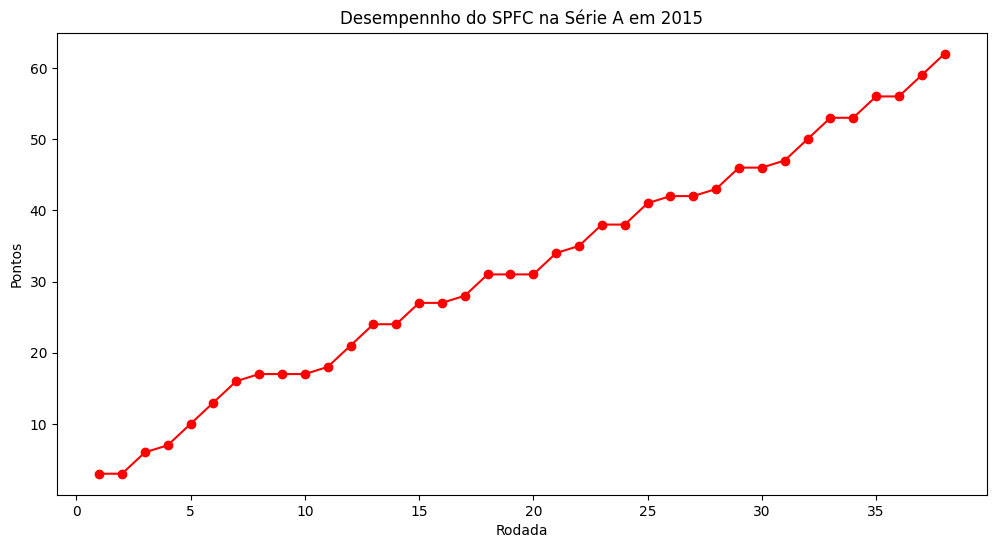

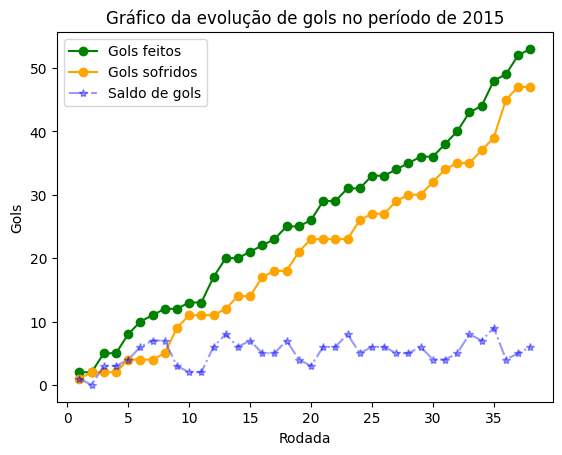

Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção dos anos
Digite 6 para voltar


,rodada,adversario,gols spfc,gols adv,mandante,ano,mês,dia,cidade
0,1,Flamengo,2,1,True,2015.0,5,10,São Paulo
1,2,Ponte Preta,0,1,False,2015.0,5,17,Campinas
2,3,Joinville,3,0,True,2015.0,5,23,São Paulo
3,4,Internacional,0,0,False,2015.0,5,31,Porto Alegre
4,5,Santos,3,2,True,2015.0,6,3,São Paulo
5,6,Grêmio,2,0,True,2015.0,6,6,São Paulo
6,7,Chapecoense,1,0,False,2015.0,6,13,Chapecó
7,8,Avaí,1,1,True,2015.0,6,21,São Paulo
8,9,Palmeiras,0,4,False,2015.0,6,28,São Paulo
9,10,Athletico Paranaense,1,2,False,2015.0,7,1,Curitiba


Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção dos anos
Digite 6 para voltar

Digite um ano entre 2006 e 2025
Digite "casa" para saber os resultados em casa
Digite "visita" para saber os resultados fora
Digite qualquer outro caracter para saber todos os resultados

No ano de 2008 o SPFC 
venceu 14 partidas, 
empatou 4 e
perdeu 1
conquistando um total de 46 pontos
marcando um total de 38 gols e sofrendo 12


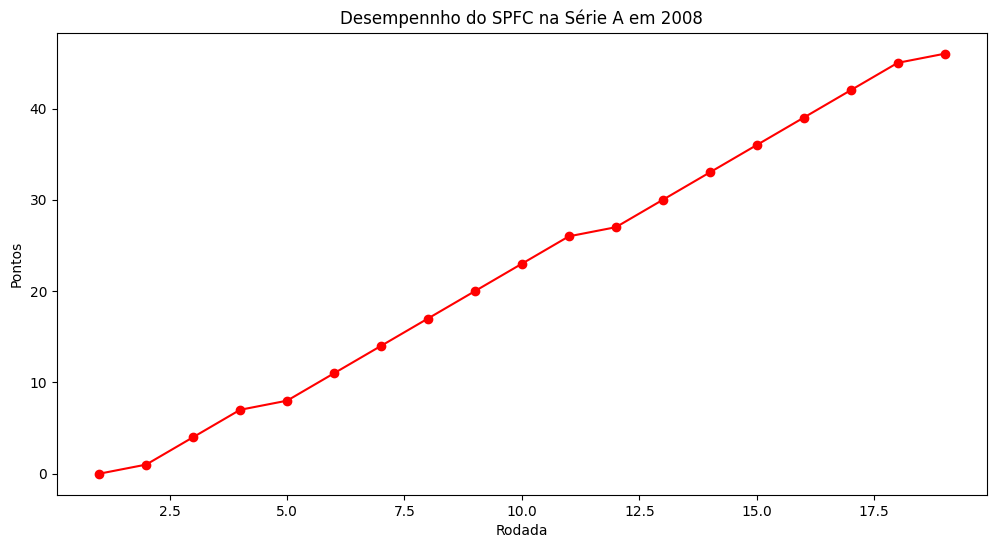

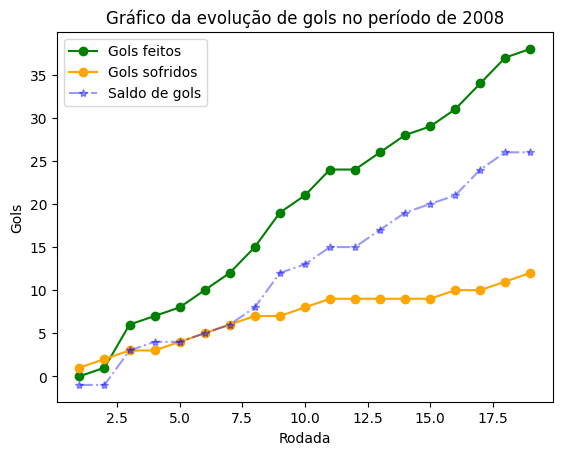

Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção dos anos
Digite 6 para voltar


,rodada,adversario,gols spfc,gols adv,mandante,ano,mês,dia,cidade
0,1,Grêmio,0,1,True,2008.0,5,10,São Paulo
1,3,Coritiba,1,1,True,2008.0,5,25,São Paulo
2,5,Atlético Mineiro,5,1,True,2008.0,6,7,São Paulo
3,7,Sport,1,0,True,2008.0,6,21,São Paulo
4,9,Ipatinga,1,1,True,2008.0,7,6,São Paulo
5,11,Palmeiras,2,1,True,2008.0,7,13,São Paulo
6,13,Botafogo,2,1,True,2008.0,7,20,São Paulo
7,15,Portuguesa,3,1,True,2008.0,7,27,São Paulo
8,17,Vasco,4,0,True,2008.0,8,3,São Paulo
9,19,Goiás,2,1,True,2008.0,8,9,São Paulo


Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção dos anos
Digite 6 para voltar


,rodada,adversario,gols spfc,gols adv,mandante,ano,mês,dia,cidade
1,3,Coritiba,1,1,True,2008.0,5,25,São Paulo
4,9,Ipatinga,1,1,True,2008.0,7,6,São Paulo
11,23,Santos,0,0,True,2008.0,8,31,São Paulo
18,37,Fluminense,1,1,True,2008.0,11,30,São Paulo


Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção dos anos
Digite 6 para voltar


,rodada,adversario,gols spfc,gols adv,mandante,ano,mês,dia,cidade
0,1,Grêmio,0,1,True,2008.0,5,10,São Paulo


Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção dos anos
Digite 6 para voltar


,rodada,adversario,gols spfc,gols adv,mandante,ano,mês,dia,cidade
1,3,Coritiba,1,1,True,2008.0,5,25,São Paulo
4,9,Ipatinga,1,1,True,2008.0,7,6,São Paulo
11,23,Santos,0,0,True,2008.0,8,31,São Paulo
18,37,Fluminense,1,1,True,2008.0,11,30,São Paulo


Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção dos anos
Digite 6 para voltar
Qual informação você quer saber?
Digite 1 para saber sobre alguma temporada específica
Digite 2 para saber sobre um intervalo de tempo
Digite 3 para saber em quais cidades jogamos
Digite 4 para voltar
Digite o ano de inicio (de 2006 a 2025)
Digite o ano final (de 2017 a 2025)
Digite o mês de inicio (1 até 12)
Digite o mês final
Digite o dia de inicio (1 até 31)
Digite o dia final
Digite "casa" para saber os resultados em casa
Digite "visita" para saber os resultados fora
Digite qualquer outro caracter para saber todos os resultados
Entre 1/1/2017 e 31/12/2018 o SPFC jogou 38 partidas contra 23 adversários diferentes
Com 10 vitórias, 
18 derrotas e 
10 empates, fazendo 40 pontos
Marcando um total de 40 gols e sofrendo 52.


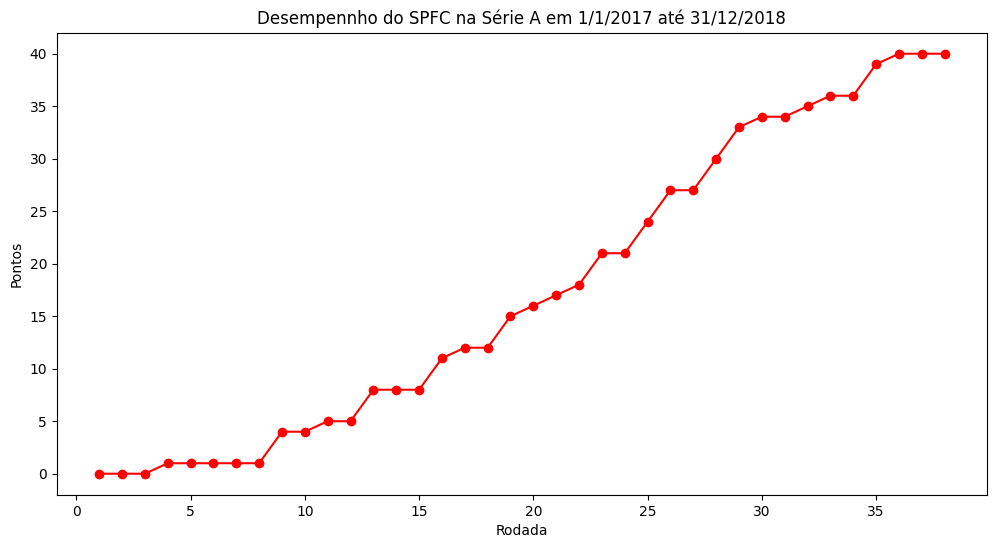

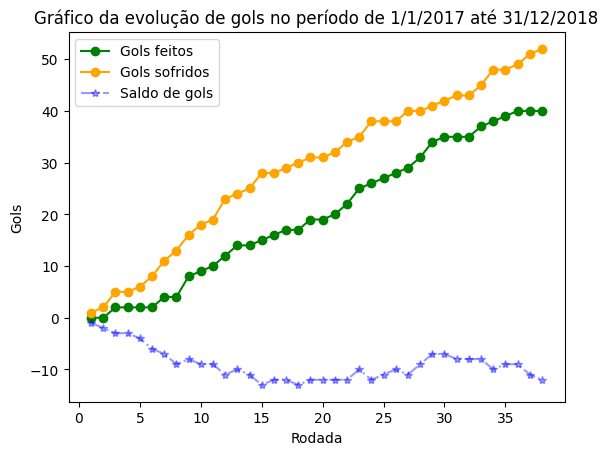

Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção do intervalo de tempo
Digite 6 para voltar


,rodada,adversario,gols spfc,gols adv,mandante,ano,mês,dia,cidade
0,1,Cruzeiro,0,1,False,2017.0,5,14,Belo Horizonte
1,4,Ponte Preta,0,1,False,2017.0,6,4,Campinas
2,6,Corinthians,2,3,False,2017.0,6,11,São Paulo
4,9,Athletico Paranaense,0,1,False,2017.0,6,21,Curitiba
5,11,Flamengo,0,2,False,2017.0,7,2,Rio de Janeiro
6,12,Santos,2,3,False,2017.0,7,9,Santos
7,14,Chapecoense,0,2,False,2017.0,7,16,Chapecó
9,19,Bahia,1,2,False,2017.0,8,6,Salvador
11,22,Palmeiras,2,4,False,2017.0,8,27,São Paulo
13,27,Atlético Mineiro,0,1,False,2017.0,10,11,Belo Horizonte


Qual informação a mais você deseja?
Digite 1 para ver a tabela dos jogos
Digite 2 para ver a tabela das vitórias
Digite 3 para ver a tabela dos empates
Digite 4 para ver a tabela das derrotas
Digite 5 para voltar a seleção do intervalo de tempo
Digite 6 para voltar
6
Qual informação você quer saber?
Digite 1 para saber sobre alguma temporada específica
Digite 2 para saber sobre um intervalo de tempo
Digite 3 para saber em quais cidades jogamos
Digite 4 para voltar


In [ ]:
main()